Create a TS+biology tracers initial file for one bathymetry based on a restart file from a different bathymetry

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np 

from salishsea_tools import nc_tools

%matplotlib inline

# New Bathymetry (via its mesh mask)

In [2]:
mesh = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
mbathy = mesh.variables['mbathy'][0,:,:]
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
gdepw = mesh.variables['gdepw_0'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)
tmask = mesh.variables['tmask'][0,:,:,:]
tmask = np.abs(tmask-1)
lats = mesh.variables['nav_lat'][:]
lons = mesh.variables['nav_lon'][:]
mesh.close()

In [3]:
# calculate bathymetry based on meshmask
NEMO_bathy = np.zeros(mbathy.shape)
for i in range(NEMO_bathy.shape[1]):
    for j in range(NEMO_bathy.shape[0]):
        level = mbathy[j,i]
        NEMO_bathy[j,i] = gdepw[level,j,i]
NEMO_bathy = np.ma.masked_array(NEMO_bathy, mask = surface_tmask)

# Old Bathymetry (based on its mesh mask)

In [4]:
oldmesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
oldmbathy =oldmesh.variables['mbathy'][0,:,:] 
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
oldgdepw = oldmesh.variables['gdepw_0'][0,:,:,:]
oldsurface_tmask = oldmesh.variables['tmask'][0,0,:,:]
oldsurface_tmask = np.abs(oldsurface_tmask-1)
oldtmask = oldmesh.variables['tmask'][0,:,:,:]
oldtmask = np.abs(oldtmask-1)
oldmesh.close()

In [5]:
np.max(oldmbathy)

39

# Restart Files to Get Tracers (TS and Biology)

In [6]:
dataphys = nc.Dataset('/results2/SalishSea/nowcast-green.202111/10aug19/SalishSea_13903920_restart.nc')
databio = nc.Dataset('/results2/SalishSea/nowcast-green.202111/10aug19/SalishSea_13903920_restart_trc.nc')   

In [7]:
physical = ['tn', 'sn',
           'tb', 'sb']
biological = ['TRNDON', 'TRNMICZ','TRNMYRI','TRNNH4','TRNNO3','TRNTRA',
              'TRNPHY','TRNDIAT','TRNPON','TRNSi','TRNbSi',
              'TRNDIC', 'TRNTA', 'TRNO2',
             'TRBDON', 'TRBMICZ','TRBMYRI','TRBNH4','TRBNO3','TRBTRA',
              'TRBPHY','TRBDIAT','TRBPON','TRBSi','TRBbSi',
             'TRBDIC', 'TRBTA', 'TRBO2']
varas = {}
for vb in physical:
    varas[vb] = dataphys.variables[vb][0, :]
for vb in biological:
    print (vb)
    varas[vb] = databio.variables[vb][0, :]
#dataphys.close()
#databio.close()
varall = physical + biological

TRNDON
TRNMICZ
TRNMYRI
TRNNH4
TRNNO3
TRNTRA
TRNPHY
TRNDIAT
TRNPON
TRNSi
TRNbSi
TRNDIC
TRNTA
TRNO2
TRBDON
TRBMICZ
TRBMYRI
TRBNH4
TRBNO3
TRBTRA
TRBPHY
TRBDIAT
TRBPON
TRBSi
TRBbSi
TRBDIC
TRBTA
TRBO2


# Fill in any Missing Data Points

In [8]:
def find_mean(varas, varall, i, j, k, dd, oldtmask):
    for vb in varall:
        imin = max(i-dd, 0)
        imax = min(i+dd, 897)
        jmin = max(j-dd, 0)
        jmax = min(j+dd, 397)
        temporary = np.sum(varas[vb][k, imin:imax+1, jmin:jmax+1]*(1-oldtmask[k, imin:imax+1, jmin:jmax+1]))
        count = np.sum(1-oldtmask[k, imin:imax+1, jmin:jmax+1])
        if count == 0:
            varas[vb][k, i, j] = 0
        else:
            varas[vb][k, i, j] = temporary/count
    return varas

In [9]:
def fillit(kmax, oldtmask, varas, varall):
    dd = 1
    bad = 1
    while bad > 0:
        dd += 1
        good = 1
        while good > 0:
            good = 0; bad = 0; already = 0
            for k in range(kmax+1):
                for i in range(1, 898):
                    for j in range(1, 398):
                        if tmask[k,i,j] < oldtmask[k,i,j]:
                            if varas['sn'][k, i, j] > 0:
                                already = already + 1
                            else:
                                varas = find_mean(varas, varall, i, j, k, dd, oldtmask)
                                if varas['sn'][k, i, j] > 0:
                                    good = good + 1
                                else:
                                    bad = bad + 1
                                    if dd > 5:
                                        print (k, i, j)
            print ('dd', dd, 'good', good)
            print ('already', already, 'bad', bad)

This can take a very long time if the bathymetries are very different, aka add a new long river.  If you want you can do it in pieces by starting with the first argument at say 5 and then slowly increasing it.  You do need to go to 39 finally. For new bathy201702 versus old bathy201702 its fast.

In [10]:
fillit(39, oldtmask, varas, varall)

dd 2 good 172
already 0 bad 67
dd 2 good 0
already 172 bad 67
dd 3 good 17
already 172 bad 50
dd 3 good 0
already 189 bad 50
dd 4 good 16
already 189 bad 34
dd 4 good 0
already 205 bad 34
dd 5 good 11
already 205 bad 23
dd 5 good 0
already 216 bad 23
26 361 240
26 362 218
26 362 219
26 363 218
26 363 219
26 363 220
26 363 221
26 364 235
26 364 236
26 364 237
27 361 228
27 362 228
dd 6 good 11
already 216 bad 12
26 361 240
26 362 218
26 362 219
26 363 218
26 363 219
26 363 220
26 363 221
26 364 235
26 364 236
26 364 237
27 361 228
27 362 228
dd 6 good 0
already 227 bad 12
26 362 219
26 363 219
26 363 220
26 364 236
26 364 237
27 361 228
27 362 228
dd 7 good 5
already 227 bad 7
26 362 219
26 363 219
26 363 220
26 364 236
26 364 237
27 361 228
27 362 228
dd 7 good 0
already 232 bad 7
26 364 237
27 361 228
27 362 228
dd 8 good 4
already 232 bad 3
26 364 237
27 361 228
27 362 228
dd 8 good 0
already 236 bad 3
27 361 228
27 362 228
dd 9 good 1
already 236 bad 2
27 361 228
27 362 228
dd 9 goo

# Write Initial File

In [11]:
# build nc file
#new_initialfile = nc.Dataset('restart_phybio_13903920_10aug19.nc', 'w')
new_initialfile = nc.Dataset('restart_phybio_13903920_10aug19b.nc', 'w')
nc_tools.init_dataset_attrs(
    new_initialfile, 
    title='All tracers for Bathymetry 202310b from nowcast-green 10aug19b, with N and Si inc.', 
    notebook_name='/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Initial_from_Restart_Bathy202310', 
    nc_filepath='/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/restart_phybio_13903920_10aug19b.nc',
    comment='All Tracers, physical and biological')
new_initialfile.createDimension('y', 898)
new_initialfile.createDimension('x', 398)
new_initialfile.createDimension('z', 40)
new_initialfile.createDimension('t', None)

file format: NETCDF4
Conventions: CF-1.6
title: All tracers for Bathymetry 202310b from nowcast-green 10aug19b, with N and Si inc.
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2023-10-29 21:15:55] Created netCDF4 zlib=True dataset.
comment: All Tracers, physical and biological


not found!


<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 't', size = 0

In [12]:
thevara = {}
for vb in varall:
    thevara[vb] = new_initialfile.createVariable(
        vb, 'float64', ('t', 'z', 'y', 'x'), zlib=True,
        least_significant_digit=1e-5, fill_value=-99)
    thevara[vb][0] = varas[vb]
    print (vb, np.max(thevara[vb]))
new_initialfile

tn 26.25
sn 34.0625
tb 26.25
sb 34.0625
TRNDON 8.6875
TRNMICZ 1.0625
TRNMYRI 0.0
TRNNH4 5.6875
TRNNO3 36.75
TRNTRA 25.9375
TRNPHY 4.875
TRNDIAT 15.1875
TRNPON 4.5625
TRNSi 147.0625
TRNbSi 99.625
TRNDIC 2333.0
TRNTA 2326.625
TRNO2 405.25
TRBDON 8.6875
TRBMICZ 1.0625
TRBMYRI 0.0
TRBNH4 5.6875
TRBNO3 36.75
TRBTRA 25.9375
TRBPHY 4.875
TRBDIAT 15.1875
TRBPON 4.5625
TRBSi 147.125
TRBbSi 99.625
TRBDIC 2333.0
TRBTA 2326.625
TRBO2 405.25


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: All tracers for Bathymetry 202310b from nowcast-green 10aug19b, with N and Si inc.
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: REQUIRED
    references: REQUIRED
    history: [2023-10-29 21:15:55] Created netCDF4 zlib=True dataset.
    comment: All Tracers, physical and biological
    dimensions(sizes): y(898), x(398), z(40), t(1)
    variables(dimensions): float64 tn(t, z, y, x), float64 sn(t, z, y, x), float64 tb(t, z, y, x), float64 sb(t, z, y, x), float64 TRNDON(t, z, y, x), float64 TRNMICZ(t, z, y, x), float64 TRNMYRI(t, z, y, x), float64 TRNNH4(t, z, y, x), float64 TRNNO3(t, z, y, x), float64 TRNTRA(t, z, y, x), float64 TRNPHY(t, z, y, x), float64 TRNDIAT(t, z, y, x), float64 TRNPON(t, z, y, x), float64 TRNSi(t, z, y, x), float64 TRNbSi(t, z, y, x), float64 TRNDIC(t, z, y, x), float64 TRNTA(t, z, y, x)

In [13]:
new_initialfile.close()

# Copy variables in the old restart files to the new one and correct the salinity

In [14]:
var_phy_to_copy = {'nav_lon','nav_lat','nav_lev','time_counter','rnf_b', 'sfx_b', 'rotn', 'vtau_b', 'rdttra1', 'avt', 'nav_lon', 'qns_b', 'vn', 'hdivn', 'time_counter', 'en', 'hdivb', 'sshb', 'rhop', 'ndastp', 'adatrj', 'fse3t_n', 'ssh_ibb', 'avm', 'avmu', 'mxln', 'sshn', 'sbc_sc_b', 'nav_lev', 'emp_b', 'qsr_hc_b', 'sbc_hc_b', 'rnf_sc_b', 'vb2_b', 'ub2_b', 'nav_lat', 'ub', 'rotb', 'fse3t_b', 'un', 'rdt', 'utau_b', 'fraqsr_1lev', 'avmv', 'vb', 'kt', 'rnf_hc_b'}
var_bio_to_copy = {'rnf_pis_DIC_b', 'rnf_pis_MYRI_b', 'sbc_DON_b', 'sbc_bSi_b', 'nav_lon', 'rnf_pis_PON_b', 'rnf_pis_PHY_b', 'time_counter', 'rnf_pis_MICZ_b', 'sbc_TA_b', 'rdttrc1', 'rnf_pis_TRA_b', 'ndastp', 'sbc_Si_b', 'rnf_pis_TA_b', 'adatrj', 'rnf_pis_bSi_b', 'sbc_PHY_b', 'nav_lev', 'sbc_DIC_b', 'sbc_DIAT_b', 'sbc_O2_b', 'sbc_MYRI_b', 'rnf_pis_NO3_b', 'rnf_pis_DON_b', 'sbc_MICZ_b', 'sbc_PON_b', 'sbc_NH4_b', 'rnf_pis_O2_b', 'nav_lat', 'sbc_TRA_b', 'kt', 'rnf_pis_DIAT_b', 'rnf_pis_Si_b', 'rnf_pis_NH4_b', 'sbc_NO3_b'}

In [15]:
dfphy = xr.open_dataset('SalishSea_13903920_restart.nc') # Copy from /results2/SalishSea/nowcast-green.202111/10aug19/
dfbio = xr.open_dataset('SalishSea_13903920_restart_trc.nc') # same as above
#dfnew = xr.open_dataset('restart_phybio_13903920_10aug19.nc')
dfnew = xr.open_dataset('restart_phybio_13903920_10aug19b.nc')

In [16]:
dfnew[var_phy_to_copy]=dfphy[var_phy_to_copy]
dfnew[var_bio_to_copy]=dfbio[var_bio_to_copy]
dfnew

<xarray.Dataset>
Dimensions:         (t: 1, z: 40, y: 898, x: 398)
Dimensions without coordinates: t, z, y, x
Data variables: (12/104)
    tn              (t, z, y, x) float64 ...
    sn              (t, z, y, x) float64 ...
    tb              (t, z, y, x) float64 ...
    sb              (t, z, y, x) float64 ...
    TRNDON          (t, z, y, x) float64 ...
    TRNMICZ         (t, z, y, x) float64 ...
    ...              ...
    rnf_pis_bSi_b   (t, y, x) float64 ...
    rnf_pis_TA_b    (t, y, x) float64 ...
    sbc_MICZ_b      (t, y, x) float64 ...
    rnf_pis_O2_b    (t, y, x) float64 ...
    rnf_pis_TRA_b   (t, y, x) float64 ...
    sbc_DIC_b       (t, y, x) float64 ...
Attributes:
    Conventions:  CF-1.6
    title:        All tracers for Bathymetry 202310b from nowcast-green 10aug...
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       REQUIRED
    references:   REQUIRED
    history:      [2023-10-29 21:15:55] Created netCDF4 zlib=True dataset.
    comment:      All Tracers, physical and biological

In [17]:
#dfnew.to_netcdf('restart_PHYBIO_13903920_10aug19_202310.nc', mode='w')
dfnew.to_netcdf('restart_PHYBIO_13903920_10aug19_202310b.nc', mode='w')

In [23]:
#
Sn = dfnew.variables['sn']
Sb = dfnew.variables['sb']
Sn.shape

(1, 40, 898, 398)

In [24]:
kk = np.arange(1, 40)
jj = np.arange(0, 898)
ii = np.arange(0, 398)
# box where changes took place (in all salish sea takes too much time, and not necessary I think)
pointsi = np.arange(200, 250).astype(int)
pointsj = np.arange(350, 380).astype(int)

#SSn = np.ones((1, 40, 898, 398))
for k in kk:
    for j in pointsj:
        for i in pointsi:
            diffsn = Sn[:, k, j, i] - Sn[:, k-1, j, i]
            if diffsn < 0:
                Sn[:, k, j, i] = Sn[:, k-1, j, i]
#            else:
#                sn[:, k, j, i] = sn[:, k, j, i]

Sn.shape


(1, 40, 898, 398)

In [25]:
for k in kk:
    for j in pointsj:
        for i in pointsi:
            diffsb = Sb[:, k, j, i] - Sb[:, k-1, j, i]
            if diffsb < 0:
                Sb[:, k, j, i] = Sb[:, k-1, j, i]

Sb.shape

(1, 40, 898, 398)

In [26]:
dfnew2 = dfnew
dfnew2['sn'] = Sn
dfnew2['sb'] = Sb


In [27]:
#dfnew2.to_netcdf('restart_PHYBIO_13903920_10aug19_202310_snsbCorrected.nc', mode='w')
dfnew2.to_netcdf('restart_PHYBIO_13903920_10aug19_202310b_snsbCorrected.nc', mode='w')

In [28]:
#dfA = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310.nc')
#dfB = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310_snsbCorrected.nc')
dfA = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310b.nc')
dfB = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310b_snsbCorrected.nc')
snA = dfA['sn']
snB = dfB['sn']

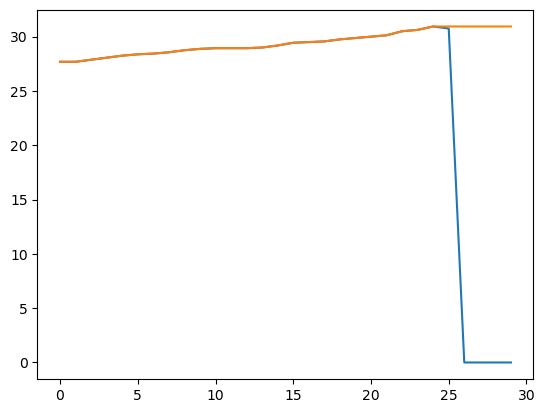

In [29]:
import matplotlib.pyplot as plt
plt.plot(snA[0, :30, 363, 235])
plt.plot(snB[0, :30, 363, 235])
